#EEL891 - 2021.02 - Trabalho 1

##Classificação: sistema de apoio à decisão p/ aprovação de crédito

Matheus Lomba de Rezende Conde

DRE: 117085216

##Preparando o ambiente

###Importando as bibliotecas necessárias



In [198]:
#Bibliotecas de análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

import io #Leitura do csv importado

In [199]:
#Biblioteca para importação das bases de dados
from google.colab import files
uploaded = files.upload()

Saving conjunto_de_teste.csv to conjunto_de_teste (6).csv
Saving conjunto_de_treinamento.csv to conjunto_de_treinamento (5).csv


###Carregando o dataset

In [201]:
#Carga do dataset de treinamento
df_treino = pd.read_csv(io.BytesIO(uploaded['conjunto_de_treinamento.csv']))

#Carga do dataset de teste
df_teste = pd.read_csv(io.BytesIO(uploaded['conjunto_de_teste.csv']))

##Analisando o Dataset

###Número de Registros e Atributos nos datasets

In [121]:
print(f'Shape treino: {df_treino.shape}')
print(f'Shape teste: {df_teste.shape}')

Shape treino: (20000, 42)
Shape teste: (5000, 41)


###Amostra do Dataset

In [122]:
df_treino.head()

id_solicitante  produto_solicitado  dia_vencimento forma_envio_solicitacao  \
0               1                   1              10              presencial   
1               2                   1              25                internet   
2               3                   1              20                internet   
3               4                   1              20                internet   
4               5                   7               1                internet   

   tipo_endereco sexo  idade  estado_civil  qtde_dependentes  grau_instrucao  \
0              1    M     85             2                 0               0   
1              1    F     38             1                 0               0   
2              1    F     37             2                 0               0   
3              1    M     37             1                 1               0   
4              1    F     51             1                 3               0   

   ...  possui_telefone_trabalho codigo_area_telefone_trabalho  \
0  ...                         N                                 
1  ...                         N                                 
2  ...                         N                                 
3  ...                         Y                            54   
4  ...                         N                                 

  meses_no_trabalho profissao ocupacao  profissao_companheiro  \
0                 0       9.0      1.0                    0.0   
1                 0       2.0      5.0                    NaN   
2                 0       NaN      NaN                    NaN   
3                 0       9.0      2.0                    NaN   
4                 0       9.0      5.0                    NaN   

   grau_instrucao_companheiro local_onde_reside  local_onde_trabalha  \
0                         0.0             600.0                600.0   
1                         NaN             492.0                492.0   
2                         NaN             450.0                450.0   
3                         NaN             932.0                932.0   
4                         NaN             440.0                440.0   

   inadimplente  
0             0  
1             0  
2             1  
3             1  
4             1  

[5 rows x 42 columns]

###Matriz de Correlação

In [123]:
#Seta o tamanho de plotagem
sns.set(rc={'figure.figsize':(150,150)})
sns.set_context(context='paper',font_scale=7)
#Plota a matriz de correlação
sns.heatmap(df_treino.loc[:, df_treino.columns != 'SalePrice'].corr(), annot = True, cmap='nipy_spectral', vmin=-1, vmax=1)

###Analisando atributos com valores vazios

[]

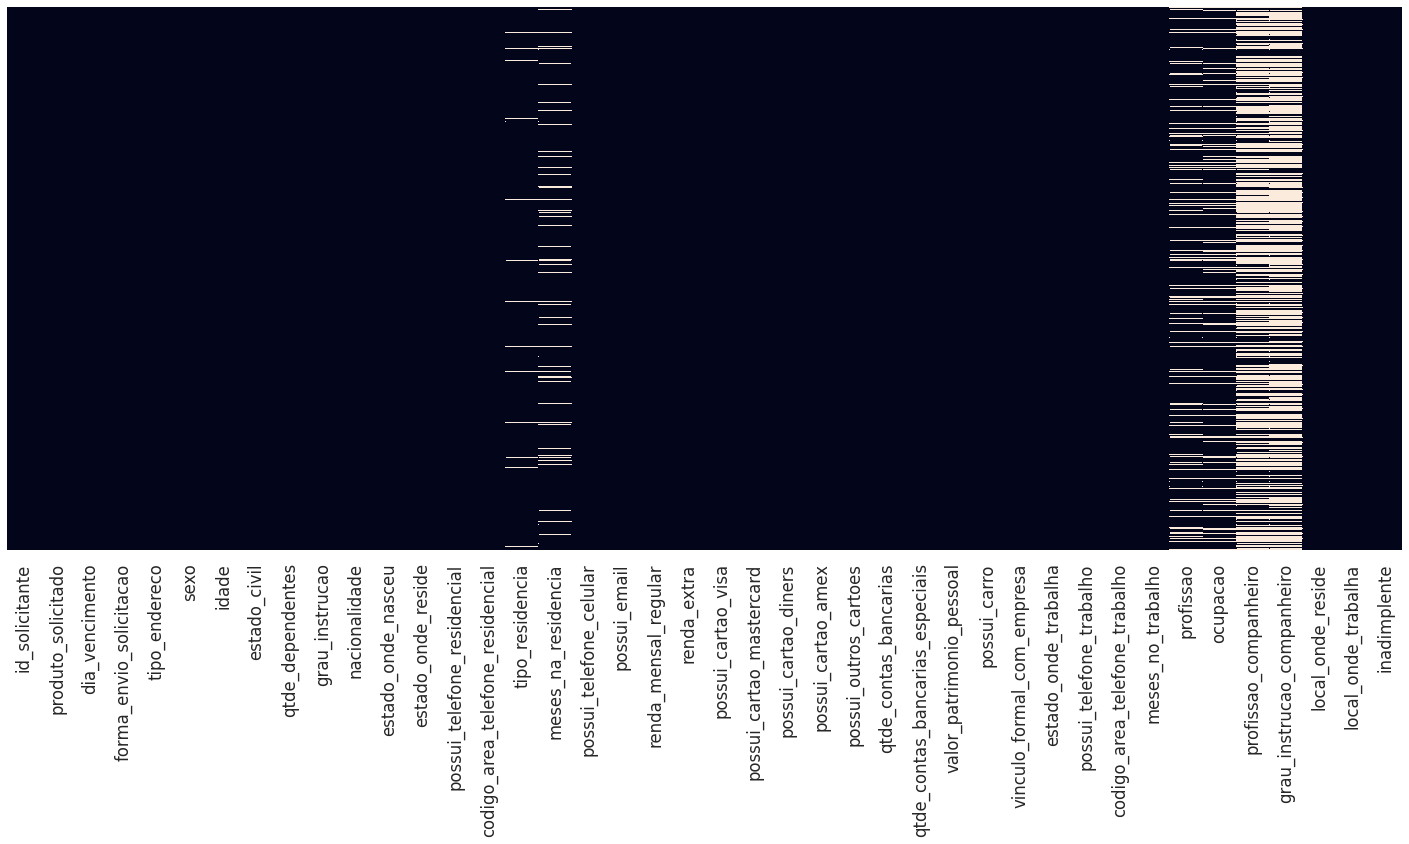

In [124]:
plt.figure(figsize=(25,10))
sns.set_context('talk')

hm = sns.heatmap(df_treino.isnull(),yticklabels=False,cbar=False)
hm.set_yticklabels(labels=hm.get_yticklabels(), va='center')

Calculando a porcentagem de valores vazios em cada coluna:

In [125]:
#Troca valores " " por Nulo
df_treino = df_treino.replace(" ", np.nan)

#Calcula o número de valores nulos ou " " em cada coluna
num_nulos = df_treino.isna().sum()
#Filtro - aparecer apenas colunas com nulos
num_nulos = num_nulos[num_nulos > 0]

#Calcula o percentual de nulos em cada coluna
num_linhas = df_treino.shape[0]
perc_nulos = num_nulos.apply(lambda x:(x/num_linhas)*100)
decrescente_perc_nulos = pd.Series(perc_nulos).sort_values(ascending=False)
decrescente_perc_nulos

codigo_area_telefone_trabalho       72.625
estado_onde_trabalha                67.865
grau_instrucao_companheiro          64.300
profissao_companheiro               57.570
codigo_area_telefone_residencial    17.670
profissao                           15.485
ocupacao                            14.890
meses_na_residencia                  7.250
estado_onde_nasceu                   4.110
tipo_residencia                      2.680
sexo                                 0.035
dtype: float64

###Variáveis Categóricas e Cardinalidade

In [126]:
df_treino.dtypes

id_solicitante                        int64
produto_solicitado                    int64
dia_vencimento                        int64
forma_envio_solicitacao              object
tipo_endereco                         int64
sexo                                 object
idade                                 int64
estado_civil                          int64
qtde_dependentes                      int64
grau_instrucao                        int64
nacionalidade                         int64
estado_onde_nasceu                   object
estado_onde_reside                   object
possui_telefone_residencial          object
codigo_area_telefone_residencial     object
tipo_residencia                     float64
meses_na_residencia                 float64
possui_telefone_celular              object
possui_email                          int64
renda_mensal_regular                float64
renda_extra                         float64
possui_cartao_visa                    int64
possui_cartao_mastercard        

####Identificando Variáveis Categóricas:

In [127]:
variaveis_categoricas = [
  x for x in df_treino.columns if df_treino[x].dtypes=="object"
]
print(variaveis_categoricas)

['forma_envio_solicitacao', 'sexo', 'estado_onde_nasceu', 'estado_onde_reside', 'possui_telefone_residencial', 'codigo_area_telefone_residencial', 'possui_telefone_celular', 'vinculo_formal_com_empresa', 'estado_onde_trabalha', 'possui_telefone_trabalho', 'codigo_area_telefone_trabalho']


####Verificando a Cardinalidade das Variáveis Categóricas:

In [128]:
for v in variaveis_categoricas:
  print("\n%15s:"%v, "%4d categorias" % len(df_treino[v].unique()))
  print(df_treino[v].unique())


forma_envio_solicitacao:    3 categorias
['presencial' 'internet' 'correio']

           sexo:    4 categorias
['M' 'F' 'N' nan]

estado_onde_nasceu:   28 categorias
['CE' 'SE' 'BA' 'RS' 'SP' 'ES' 'GO' 'PR' 'AC' 'PE' nan 'MA' 'MG' 'MT' 'RN'
 'PA' 'SC' 'PI' 'RR' 'RJ' 'AL' 'AM' 'DF' 'MS' 'PB' 'TO' 'AP' 'RO']

estado_onde_reside:   27 categorias
['CE' 'SE' 'BA' 'RS' 'SP' 'ES' 'GO' 'MG' 'AC' 'PE' 'PR' 'PB' 'MA' 'RJ'
 'MT' 'RN' 'PA' 'SC' 'PI' 'AP' 'RR' 'RO' 'AL' 'MS' 'AM' 'DF' 'TO']

possui_telefone_residencial:    2 categorias
['Y' 'N']

codigo_area_telefone_residencial:   81 categorias
['107' '91' '90' '54' '86' '16' '25' '67' nan '81' '10' '58' '32' '76'
 '97' '40' '5' '9' '14' '84' '103' '20' '112' '111' '117' '48' '29' '114'
 '122' '77' '71' '100' '85' '105' '50' '44' '33' '118' '66' '125' '22'
 '120' '12' '38' '62' '18' '73' '27' '41' '39' '126' '75' '30' '68' '61'
 '69' '15' '123' '46' '110' '24' '31' '119' '52' '13' '109' '43' '47' '95'
 '83' '124' '70' '2' '17' '1' '113' '36' '6' 

forma_envio_solicitacao --> não-ordinal com 3 categorias **-> one-hot encoding**

sexo --> não-ordinal com 4 categorias **-> tratamento do nulo e one-hot encoding**

estado_onde_nasceu --> não-ordinal com 28 categorias **-> descartar**

estado_onde_reside --> não-ordinal com 27 categorias **-> descartar**

possui_telefone_residencial --> binária **-> binarizar (mapear para 0 ou 1)**

codigo_area_telefone_residencial --> não-ordinal com 81 categorias **-> descartar**

possui_telefone_celular -> binária  **-> binarizar (mapear para 0 ou 1)**

vinculo_formal_com_empresa --> binária **-> binarizar (mapear para 0 ou 1)**

estado_onde_trabalha --> não-ordinal com 28 categorias **-> descartar**

possui_telefone_trabalho --> binária **-> binarizar (mapear para 0 ou 1)**

codigo_area_telefone_trabalho --> não-ordinal com 77 categorias **-> descartar**

##Tratamento do Dataset

###Exclusão de atributos desnecessários

In [202]:
#Decisão feita com base no dicionário de dados fornecido no Kaggle e a Matriz de Correlação acima.
del df_treino["id_solicitante"] #Dicionário
del df_treino["possui_telefone_celular"] #Apenas valor N
del df_treino["possui_carro"] #Matriz de Correlação
del df_treino["grau_instrucao"] #Coluna totalmente vazia
del df_treino["meses_no_trabalho"] #Grande maioria da coluna vazia

#Remoção baseada na cardinalidade das variáveis categóricas
del df_treino["estado_onde_nasceu"]
del df_treino["estado_onde_reside"]
del df_treino["codigo_area_telefone_residencial"]
del df_treino["estado_onde_trabalha"]
del df_treino["codigo_area_telefone_trabalho"]

In [130]:
df_treino.columns

Index(['produto_solicitado', 'dia_vencimento', 'forma_envio_solicitacao',
       'tipo_endereco', 'sexo', 'idade', 'estado_civil', 'qtde_dependentes',
       'nacionalidade', 'possui_telefone_residencial', 'tipo_residencia',
       'meses_na_residencia', 'possui_email', 'renda_mensal_regular',
       'renda_extra', 'possui_cartao_visa', 'possui_cartao_mastercard',
       'possui_cartao_diners', 'possui_cartao_amex', 'possui_outros_cartoes',
       'qtde_contas_bancarias', 'qtde_contas_bancarias_especiais',
       'valor_patrimonio_pessoal', 'vinculo_formal_com_empresa',
       'possui_telefone_trabalho', 'profissao', 'ocupacao',
       'profissao_companheiro', 'grau_instrucao_companheiro',
       'local_onde_reside', 'local_onde_trabalha', 'inadimplente'],
      dtype='object')

###Tratamento - Colunas com valor nulo

Observando-se novamente os atributos com valores vazios:

In [203]:
#Recalculando o a porcentagem de nulos
df_treino = df_treino.replace(" ", np.nan)
num_nulos = df_treino.isna().sum()
num_nulos = num_nulos[num_nulos > 0]
num_linhas = df_treino.shape[0]
perc_nulos = num_nulos.apply(lambda x:(x/num_linhas)*100)
decrescente_perc_nulos = pd.Series(perc_nulos).sort_values(ascending=False)
decrescente_perc_nulos

grau_instrucao_companheiro    64.300
profissao_companheiro         57.570
profissao                     15.485
ocupacao                      14.890
meses_na_residencia            7.250
tipo_residencia                2.680
sexo                           0.035
dtype: float64

Levando-se em consideração que existem diversas colunas com mais de 50% de valores nulos e que, devido à pouca quantidade não serão de bom uso para o estudo, elas serão removidas da base.

In [204]:
for p in decrescente_perc_nulos:
  if p >= 50:
    del df_treino[decrescente_perc_nulos[decrescente_perc_nulos == p].index[0]]

Já em relação aos outros atributos listados, será utilizada a média (arredondada para inteiros) para preencher os campos nulos das variáveis numéricas e um valor neutro para o preenchimento das variáveis categóricas.

In [205]:
for p in decrescente_perc_nulos:
  if p < 50:
    atributo = decrescente_perc_nulos[decrescente_perc_nulos == p].index[0]
    print(atributo, " - ", df_treino[atributo].dtypes)

profissao  -  float64
ocupacao  -  float64
meses_na_residencia  -  float64
tipo_residencia  -  float64
sexo  -  object


In [206]:
#Preenchimento dos campos nulos em "sexo" por "N":
df_treino[["sexo"]] = df_treino[["sexo"]].fillna(value="N")

In [207]:
#Preenchimento dos campos nulos em "profissao", "ocupacao", "meses_na_residencia" e "tipo_residencia" pela média respectiva.
for p in decrescente_perc_nulos:
  atributo = decrescente_perc_nulos[decrescente_perc_nulos == p].index[0]
  if p < 50 and atributo != "sexo":
    df_treino[[atributo]] = df_treino[[atributo]].fillna(value=df_treino[[atributo]].mean().round())

In [136]:
df_treino.describe()

produto_solicitado  dia_vencimento  tipo_endereco         idade  \
count        20000.000000    20000.000000   20000.000000  20000.000000   
mean             1.284350       13.147250       1.006350     42.352500   
std              1.008239        6.748507       0.079435     14.930177   
min              1.000000        1.000000       1.000000      7.000000   
25%              1.000000       10.000000       1.000000     31.000000   
50%              1.000000       10.000000       1.000000     40.000000   
75%              1.000000       20.000000       1.000000     52.000000   
max              7.000000       25.000000       2.000000    106.000000   

       estado_civil  qtde_dependentes  nacionalidade  tipo_residencia  \
count  20000.000000      20000.000000   20000.000000      20000.00000   
mean       2.120850          0.666400       0.961600          1.25430   
std        1.332004          1.236725       0.202305          0.87268   
min        0.000000          0.000000       0.000000          0.00000   
25%        1.000000          0.000000       1.000000          1.00000   
50%        2.000000          0.000000       1.000000          1.00000   
75%        2.000000          1.000000       1.000000          1.00000   
max        7.000000         53.000000       2.000000          5.00000   

       meses_na_residencia  possui_email  ...  possui_cartao_amex  \
count         20000.000000  20000.000000  ...        20000.000000   
mean              9.603450      0.799200  ...            0.002050   
std              10.256849      0.400609  ...            0.045232   
min               0.000000      0.000000  ...            0.000000   
25%               2.000000      1.000000  ...            0.000000   
50%               7.000000      1.000000  ...            0.000000   
75%              13.000000      1.000000  ...            0.000000   
max             228.000000      1.000000  ...            1.000000   

       possui_outros_cartoes  qtde_contas_bancarias  \
count           20000.000000           20000.000000   
mean                0.002250               0.361100   
std                 0.047382               0.481164   
min                 0.000000               0.000000   
25%                 0.000000               0.000000   
50%                 0.000000               0.000000   
75%                 0.000000               1.000000   
max                 1.000000               2.000000   

       qtde_contas_bancarias_especiais  valor_patrimonio_pessoal  \
count                     20000.000000              2.000000e+04   
mean                          0.361100              2.095614e+03   
std                           0.481164              4.403344e+04   
min                           0.000000              0.000000e+00   
25%                           0.000000              0.000000e+00   
50%                           0.000000              0.000000e+00   
75%                           1.000000              0.000000e+00   
max                           2.000000              6.000000e+06   

          profissao      ocupacao  local_onde_reside  local_onde_trabalha  \
count  20000.000000  20000.000000       20000.000000         20000.000000   
mean       8.038100      2.602800         581.295250           581.295250   
std        2.951776      1.423774         227.369798           227.369798   
min        0.000000      0.000000         105.000000           105.000000   
25%        8.000000      2.000000         444.000000           444.000000   
50%        9.000000      2.000000         596.000000           596.000000   
75%        9.000000      4.000000         728.000000           728.000000   
max       17.000000      5.000000         999.000000           999.000000   

       inadimplente  
count  20000.000000  
mean       0.500000  
std        0.500013  
min        0.000000  
25%        0.000000  
50%        0.500000  
75%        1.000000  
max        1.000000  

[8 rows x 25 columns]

Calculando novamente a porcentagem de nulos:

In [208]:
#Calcula o número de valores nulos em cada coluna
num_nulos = df_treino.isna().sum()
#Filtro - aparecer apenas colunas com nulos
num_nulos = num_nulos[num_nulos > 0]

#Calcula o percentual de nulos em cada coluna
num_linhas = df_treino.shape[0]
perc_nulos = num_nulos.apply(lambda x:(x/num_linhas)*100)
decrescente_perc_nulos = pd.Series(perc_nulos).sort_values(ascending=False)
decrescente_perc_nulos

#retorno vazio

Series([], dtype: int64)

In [138]:
df_treino.head()

produto_solicitado  dia_vencimento forma_envio_solicitacao  tipo_endereco  \
0                   1              10              presencial              1   
1                   1              25                internet              1   
2                   1              20                internet              1   
3                   1              20                internet              1   
4                   7               1                internet              1   

  sexo  idade  estado_civil  qtde_dependentes  nacionalidade  \
0    M     85             2                 0              1   
1    F     38             1                 0              1   
2    F     37             2                 0              1   
3    M     37             1                 1              1   
4    F     51             1                 3              1   

  possui_telefone_residencial  ...  qtde_contas_bancarias  \
0                           Y  ...                      1   
1                           Y  ...                      0   
2                           Y  ...                      0   
3                           Y  ...                      0   
4                           Y  ...                      0   

   qtde_contas_bancarias_especiais  valor_patrimonio_pessoal  \
0                                1                       0.0   
1                                0                       0.0   
2                                0                       0.0   
3                                0                       0.0   
4                                0                       0.0   

   vinculo_formal_com_empresa  possui_telefone_trabalho  profissao  ocupacao  \
0                           N                         N        9.0       1.0   
1                           N                         N        2.0       5.0   
2                           N                         N        8.0       3.0   
3                           Y                         Y        9.0       2.0   
4                           Y                         N        9.0       5.0   

   local_onde_reside  local_onde_trabalha  inadimplente  
0              600.0                600.0             0  
1              492.0                492.0             0  
2              450.0                450.0             1  
3              932.0                932.0             1  
4              440.0                440.0             1  

[5 rows x 30 columns]

###Tratamento das Variáveis Categóricas

In [209]:
#Printando as colunas até agora:
print(df_treino.head(3).T)

                                          0         1         2
produto_solicitado                        1         1         1
dia_vencimento                           10        25        20
forma_envio_solicitacao          presencial  internet  internet
tipo_endereco                             1         1         1
sexo                                      M         F         F
idade                                    85        38        37
estado_civil                              2         1         2
qtde_dependentes                          0         0         0
nacionalidade                             1         1         1
possui_telefone_residencial               Y         Y         Y
tipo_residencia                         1.0       1.0       5.0
meses_na_residencia                    12.0       5.0       1.0
possui_email                              0         1         1
renda_mensal_regular                  480.0     380.0     600.0
renda_extra                             

In [210]:
#Aplicando one-hot encoding nas variáveis "sexo" e "forma_envio_solicitacao":
df_treino = pd.get_dummies(df_treino, columns=["sexo", "forma_envio_solicitacao"])
print(df_treino.head(3).T)

                                        0      1      2
produto_solicitado                      1      1      1
dia_vencimento                         10     25     20
tipo_endereco                           1      1      1
idade                                  85     38     37
estado_civil                            2      1      2
qtde_dependentes                        0      0      0
nacionalidade                           1      1      1
possui_telefone_residencial             Y      Y      Y
tipo_residencia                       1.0    1.0    5.0
meses_na_residencia                  12.0    5.0    1.0
possui_email                            0      1      1
renda_mensal_regular                480.0  380.0  600.0
renda_extra                           0.0    0.0    0.0
possui_cartao_visa                      0      0      0
possui_cartao_mastercard                0      0      0
possui_cartao_diners                    0      0      0
possui_cartao_amex                      0      0

In [211]:
#Aplicando a binarização:
binarizador = LabelBinarizer()

for v in ["possui_telefone_residencial", "vinculo_formal_com_empresa", "possui_telefone_trabalho"]:
  df_treino[v] = binarizador.fit_transform(df_treino[v])

print(df_treino.head(3).T)

                                        0      1      2
produto_solicitado                    1.0    1.0    1.0
dia_vencimento                       10.0   25.0   20.0
tipo_endereco                         1.0    1.0    1.0
idade                                85.0   38.0   37.0
estado_civil                          2.0    1.0    2.0
qtde_dependentes                      0.0    0.0    0.0
nacionalidade                         1.0    1.0    1.0
possui_telefone_residencial           1.0    1.0    1.0
tipo_residencia                       1.0    1.0    5.0
meses_na_residencia                  12.0    5.0    1.0
possui_email                          0.0    1.0    1.0
renda_mensal_regular                480.0  380.0  600.0
renda_extra                           0.0    0.0    0.0
possui_cartao_visa                    0.0    0.0    0.0
possui_cartao_mastercard              0.0    0.0    0.0
possui_cartao_diners                  0.0    0.0    0.0
possui_cartao_amex                    0.0    0.0

###Verificando o tipo de todas as colunas novamente

In [212]:
df_treino.dtypes

produto_solicitado                      int64
dia_vencimento                          int64
tipo_endereco                           int64
idade                                   int64
estado_civil                            int64
qtde_dependentes                        int64
nacionalidade                           int64
possui_telefone_residencial             int64
tipo_residencia                       float64
meses_na_residencia                   float64
possui_email                            int64
renda_mensal_regular                  float64
renda_extra                           float64
possui_cartao_visa                      int64
possui_cartao_mastercard                int64
possui_cartao_diners                    int64
possui_cartao_amex                      int64
possui_outros_cartoes                   int64
qtde_contas_bancarias                   int64
qtde_contas_bancarias_especiais         int64
valor_patrimonio_pessoal              float64
vinculo_formal_com_empresa        

##Análise Exploratória

###Atributo "Inadimplentes" VS outros atributos

In [143]:
#Verificando a quantidade de inadimplentes (1) ou bom pagador (0)
df_treino["inadimplente"].value_counts()

0    10000
1    10000
Name: inadimplente, dtype: int64

In [144]:
#Verificando a relação entre Inadimplente e outros atributos
grupo = df_treino.groupby(["inadimplente"]).mean()
grupo.T

inadimplente                                  0            1
produto_solicitado                     1.254000     1.314700
dia_vencimento                        12.605100    13.689400
tipo_endereco                          1.006700     1.006000
idade                                 44.154200    40.550800
estado_civil                           2.162500     2.079200
qtde_dependentes                       0.644600     0.688200
nacionalidade                          0.961500     0.961700
possui_telefone_residencial            0.854500     0.792900
tipo_residencia                        1.238500     1.270100
meses_na_residencia                    9.934900     9.272000
possui_email                           0.801500     0.796900
renda_mensal_regular                 967.640962   946.620913
renda_extra                           30.978984    47.214933
possui_cartao_visa                     0.109300     0.108500
possui_cartao_mastercard               0.100800     0.089100
possui_cartao_diners                   0.001500     0.001700
possui_cartao_amex                     0.002100     0.002000
possui_outros_cartoes                  0.002400     0.002100
qtde_contas_bancarias                  0.354300     0.367900
qtde_contas_bancarias_especiais        0.354300     0.367900
valor_patrimonio_pessoal            2041.801800  2149.426200
vinculo_formal_com_empresa             0.438200     0.444400
possui_telefone_trabalho               0.266900     0.281200
profissao                              8.077400     7.998800
ocupacao                               2.544500     2.661100
local_onde_reside                    585.588700   577.001800
local_onde_trabalha                  585.588700   577.001800
sexo_F                                 0.626800     0.597800
sexo_M                                 0.371800     0.400400
sexo_N                                 0.001400     0.001800
forma_envio_solicitacao_correio        0.047600     0.040500
forma_envio_solicitacao_internet       0.566300     0.560100
forma_envio_solicitacao_presencial     0.386100     0.399400

In [145]:
#Identificando quais atributos tem Média com maior diferença entre Bom Pagador e Inadimplente
listaAtributos = grupo.columns.values.tolist()
dictImpacto = {}

for v in range(0, len(listaAtributos)):
  dictImpacto[listaAtributos[v]] = abs(grupo.T[0][v] - grupo.T[1][v])/((grupo.T[0][v] + grupo.T[1][v])/2)

dictImpacto_ordenado = sorted(dictImpacto.items(), key=lambda x: x[1], reverse=True)
print(dictImpacto_ordenado)

[('renda_extra', 0.4152739656206249), ('sexo_N', 0.25), ('forma_envio_solicitacao_correio', 0.16118047673098754), ('possui_outros_cartoes', 0.1333333333333333), ('possui_cartao_diners', 0.12499999999999993), ('possui_cartao_mastercard', 0.12322274881516589), ('idade', 0.08508116403990319), ('dia_vencimento', 0.08247352107855246), ('possui_telefone_residencial', 0.07478450892315161), ('sexo_M', 0.07407407407407397), ('meses_na_residencia', 0.0690272766557852), ('qtde_dependentes', 0.0654261704681874), ('possui_telefone_trabalho', 0.052180259076810724), ('valor_patrimonio_pessoal', 0.05135697700053537), ('possui_cartao_amex', 0.048780487804877974), ('sexo_F', 0.047362404050302176), ('produto_solicitado', 0.047261260559816234), ('ocupacao', 0.044797909943138), ('estado_civil', 0.03927670509465541), ('qtde_contas_bancarias', 0.0376626973137635), ('qtde_contas_bancarias_especiais', 0.0376626973137635), ('forma_envio_solicitacao_presencial', 0.03386378103119027), ('tipo_residencia', 0.025193

###Plotar diagrama de dispersão

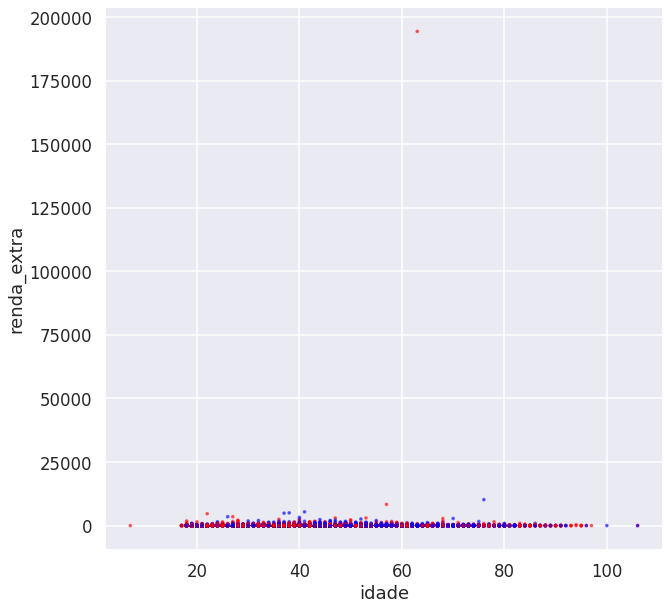

In [146]:
atr1 = "idade"
atr2 = "renda_extra"

#Inadimplente = vermelho e Bom pagador = azul
cores = [ 'red' if x else 'blue' for x in df_treino['inadimplente'] ]

grafico = df_treino.plot.scatter(
    atr1,
    atr2,
    c = cores,
    s = 5,
    alpha = 0.5,
    figsize = (10,10)
)

plt.show()

Retirando a linha que possui o outlier de renda_extra do gráfico de dispersão:

In [147]:
#Novo dataset criado sem o outlier, apenas para melhorar a visualização do gráfico de dispersão
df_dispersao = df_treino[df_treino.renda_extra != df_treino['renda_extra'].max()]
#print(df_dispersao["renda_extra"].describe())

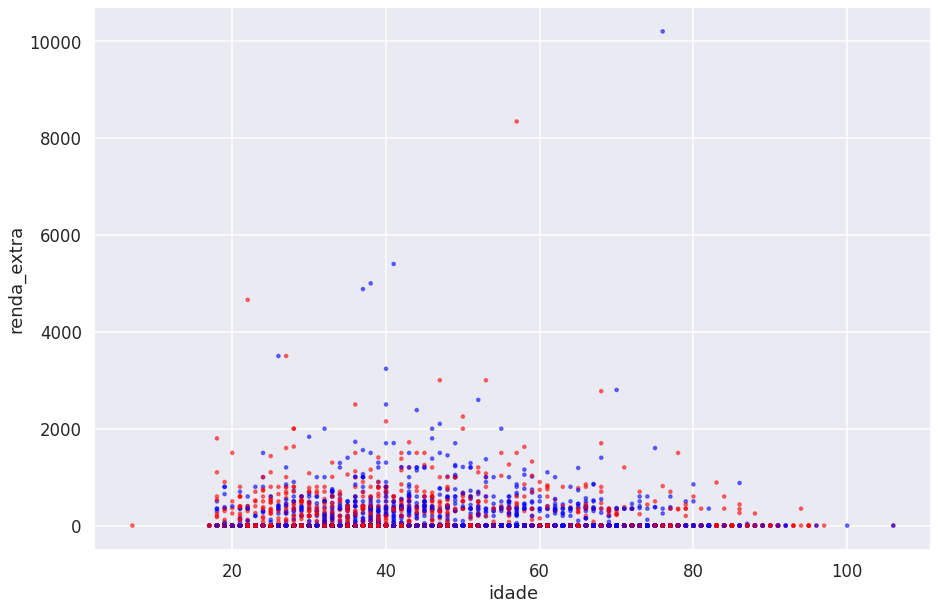

In [148]:
atr1 = "idade"
atr2 = "renda_extra"

#Inadimplente = vermelho e Bom pagador = azul
cores = [ 'red' if x else 'blue' for x in df_dispersao['inadimplente'] ]

grafico = df_dispersao.plot.scatter(
    atr1,
    atr2,
    c = cores,
    s = 10,
    alpha = 0.5,
    figsize = (15,10)
)

##Classificação

###Tratamento - Dataset Testes

In [213]:
#Decisão feita com base no dicionário de dados fornecido no Kaggle e a Matriz de Correlação acima.
#del df_teste["id_solicitante"] #Dicionário
del df_teste["possui_telefone_celular"] #Apenas valor N
del df_teste["possui_carro"] #Matriz de Correlação
del df_teste["grau_instrucao"] #Coluna totalmente vazia
del df_teste["meses_no_trabalho"] #Grande maioria da coluna vazia

#Remoção baseada na cardinalidade das variáveis categóricas
del df_teste["estado_onde_nasceu"]
del df_teste["estado_onde_reside"]
del df_teste["codigo_area_telefone_residencial"]
del df_teste["estado_onde_trabalha"]
del df_teste["codigo_area_telefone_trabalho"]

#Recalculando o a porcentagem de nulos
df_teste = df_teste.replace(" ", np.nan)
num_nulos = df_teste.isna().sum()
num_nulos = num_nulos[num_nulos > 0]
num_linhas = df_teste.shape[0]
perc_nulos = num_nulos.apply(lambda x:(x/num_linhas)*100)
decrescente_perc_nulos = pd.Series(perc_nulos).sort_values(ascending=False)
decrescente_perc_nulos

for p in decrescente_perc_nulos:
  if p >= 50:
    del df_teste[decrescente_perc_nulos[decrescente_perc_nulos == p].index[0]]

for p in decrescente_perc_nulos:
  if p < 50:
    atributo = decrescente_perc_nulos[decrescente_perc_nulos == p].index[0]

#Preenchimento dos campos nulos em "sexo" por "N":
df_teste[["sexo"]] = df_teste[["sexo"]].fillna(value="N")

#Preenchimento dos campos nulos em "profissao", "ocupacao", "meses_na_residencia" e "tipo_residencia" pela média respectiva.
for p in decrescente_perc_nulos:
  atributo = decrescente_perc_nulos[decrescente_perc_nulos == p].index[0]
  if p < 50 and atributo != "sexo":
    df_teste[[atributo]] = df_teste[[atributo]].fillna(value=df_teste[[atributo]].mean().round())

#Aplicando one-hot encoding nas variáveis "sexo" e "forma_envio_solicitacao":
df_teste = pd.get_dummies(df_teste, columns=["sexo", "forma_envio_solicitacao"])

#Aplicando a binarização:
binarizador = LabelBinarizer()
for v in ["possui_telefone_residencial", "vinculo_formal_com_empresa", "possui_telefone_trabalho"]:
  df_teste[v] = binarizador.fit_transform(df_teste[v])


#Criando uma coluna Inadimplentes no dataset de teste
df_teste["inadimplente"] = np.nan

In [151]:
df_teste.head().T

0         1        2        3  \
id_solicitante                      20001.0  20002.00  20003.0  20004.0   
produto_solicitado                      1.0      1.00      1.0      1.0   
dia_vencimento                         25.0     10.00     10.0     10.0   
tipo_endereco                           1.0      1.00      1.0      1.0   
idade                                  37.0     31.00     18.0     55.0   
estado_civil                            2.0      2.00      2.0      2.0   
qtde_dependentes                        0.0      0.00      0.0      0.0   
nacionalidade                           1.0      1.00      1.0      1.0   
possui_telefone_residencial             1.0      1.00      1.0      1.0   
tipo_residencia                         1.0      1.00      1.0      1.0   
meses_na_residencia                     5.0      1.00     12.0     25.0   
possui_email                            0.0      1.00      1.0      1.0   
renda_mensal_regular                 1800.0    424.88    400.0   1400.0   
renda_extra                             0.0      0.00      0.0      0.0   
possui_cartao_visa                      0.0      0.00      0.0      0.0   
possui_cartao_mastercard                0.0      0.00      0.0      0.0   
possui_cartao_diners                    0.0      0.00      0.0      0.0   
possui_cartao_amex                      0.0      0.00      0.0      0.0   
possui_outros_cartoes                   0.0      0.00      0.0      0.0   
qtde_contas_bancarias                   1.0      0.00      0.0      1.0   
qtde_contas_bancarias_especiais         1.0      0.00      0.0      1.0   
valor_patrimonio_pessoal                0.0      0.00      0.0      0.0   
vinculo_formal_com_empresa              0.0      1.00      1.0      0.0   
possui_telefone_trabalho                0.0      0.00      0.0      0.0   
profissao                               0.0      9.00      9.0      9.0   
ocupacao                                0.0      5.00      2.0      1.0   
local_onde_reside                     384.0    275.00    948.0    581.0   
local_onde_trabalha                   384.0    275.00    948.0    581.0   
sexo_F                                  0.0      1.00      1.0      1.0   
sexo_M                                  1.0      0.00      0.0      0.0   
sexo_N                                  0.0      0.00      0.0      0.0   
forma_envio_solicitacao_correio         0.0      0.00      0.0      0.0   
forma_envio_solicitacao_internet        0.0      1.00      1.0      0.0   
forma_envio_solicitacao_presencial      1.0      0.00      0.0      1.0   
inadimplente                            NaN       NaN      NaN      NaN   

                                          4  
id_solicitante                      20005.0  
produto_solicitado                      1.0  
dia_vencimento                         10.0  
tipo_endereco                           1.0  
idade                                  55.0  
estado_civil                            1.0  
qtde_dependentes                        0.0  
nacionalidade                           1.0  
possui_telefone_residencial             1.0  
tipo_residencia                         1.0  
meses_na_residencia                    11.0  
possui_email                            0.0  
renda_mensal_regular                  350.0  
renda_extra                             0.0  
possui_cartao_visa                      0.0  
possui_cartao_mastercard                0.0  
possui_cartao_diners                    0.0  
possui_cartao_amex                      0.0  
possui_outros_cartoes                   0.0  
qtde_contas_bancarias                   1.0  
qtde_contas_bancarias_especiais         1.0  
valor_patrimonio_pessoal                0.0  
vinculo_formal_com_empresa              0.0  
possui_telefone_trabalho                0.0  
profissao                               0.0  
ocupacao                                1.0  
local_onde_reside                     573.0  
local_onde_trabalha                   573.0  
sexo_F 

###Selecionar os atributos que serão usados pelo classificador:

In [237]:
#Lista de Colunas para usar a seguir
df_treino.columns

Index(['produto_solicitado', 'dia_vencimento', 'tipo_endereco', 'idade',
       'estado_civil', 'qtde_dependentes', 'nacionalidade',
       'possui_telefone_residencial', 'tipo_residencia', 'meses_na_residencia',
       'possui_email', 'renda_mensal_regular', 'renda_extra',
       'possui_cartao_visa', 'possui_cartao_mastercard',
       'possui_cartao_diners', 'possui_cartao_amex', 'possui_outros_cartoes',
       'qtde_contas_bancarias', 'qtde_contas_bancarias_especiais',
       'valor_patrimonio_pessoal', 'vinculo_formal_com_empresa',
       'possui_telefone_trabalho', 'profissao', 'ocupacao',
       'local_onde_reside', 'local_onde_trabalha', 'inadimplente', 'sexo_F',
       'sexo_M', 'sexo_N', 'forma_envio_solicitacao_correio',
       'forma_envio_solicitacao_internet',
       'forma_envio_solicitacao_presencial'],
      dtype='object')

In [259]:
atributos_selecionados = [
       'produto_solicitado', 
       'dia_vencimento', 
       #'tipo_endereco', 
       'idade',
       'estado_civil', 
       'qtde_dependentes', 
       #'nacionalidade',
       'possui_telefone_residencial', 
       'tipo_residencia', 
       'meses_na_residencia',
       #'possui_email', 
       'renda_mensal_regular', 
       'renda_extra',
       #'possui_cartao_visa', 
       'possui_cartao_mastercard',
       #'possui_cartao_diners', 
       #'possui_cartao_amex', 
       #'possui_outros_cartoes',
       #'qtde_contas_bancarias', 
       #'qtde_contas_bancarias_especiais',
       'valor_patrimonio_pessoal', 
       #'vinculo_formal_com_empresa',
       'possui_telefone_trabalho', 
       #'profissao', 
       'ocupacao',
       'local_onde_reside', 
       'local_onde_trabalha', 
       'sexo_F',
       'sexo_M', 
       #'sexo_N', 
       #'forma_envio_solicitacao_correio',
       #'forma_envio_solicitacao_internet',
       #'forma_envio_solicitacao_presencial',
       'inadimplente'
]

df_treino1 = df_treino[atributos_selecionados]
df_teste1 = df_teste[atributos_selecionados]

###Criando arrays X e Y para separar os Atributos e o Alvo

In [260]:
#Montando base de treino e base de teste
df_emb = df_treino1.sample(frac=1, random_state=12345)
x = df_emb.loc[:, df_emb.columns != "inadimplente"].values
y = df_emb.loc[:, df_emb.columns == "inadimplente"].values

#Definindo conjunto de treino e de teste - como já estão separados, só será realizada a divisão entre x e y
q = 15000
#Treino
x_treino = x[:q,:]
y_treino = y[:q].ravel()

#Teste
x_teste = x[q:,:]
y_teste = y[q:].ravel()

'''#Definindo conjunto de treino e de teste - como já estão separados, só será realizada a divisão entre x e y
#Treino
x_treino = df_treino1.loc[:, df_treino1.columns != "inadimplente"].values
y_treino = df_treino1.loc[:, df_treino1.columns == "inadimplente"].values.ravel()

#Teste
x_teste = df_teste1.loc[:, df_teste1.columns != "inadimplente"].values
y_teste = df_teste1.loc[:, df_teste1.columns == "inadimplente"].values.ravel()'''

#Avaliação
x_avaliacao = df_teste1.loc[:, df_teste1.columns != "inadimplente"].values
#y_avaliacao = df_teste1.loc[:, df_teste1.columns == "inadimplente"].values.ravel()

###Normalizando o Dataset - MinMaxScaler

In [261]:
ajuste = MinMaxScaler()
ajuste.fit(x_treino)

x_treino = ajuste.transform(x_treino)
x_teste = ajuste.transform(x_teste)
x_avaliacao = ajuste.transform(x_avaliacao)

###Treinando um classificador KNN

In [156]:
classificador = KNeighborsClassifier(n_neighbors = 10)
classificador = classificador.fit(x_treino, y_treino)

####Obtendo as respostas do classificador no conjunto de treino

In [157]:
y_resposta_treino = classificador.predict(x_treino)

####Obtendo as respostas do classificador no conjunto de teste

In [158]:
y_resposta_teste = classificador.predict(x_teste)

####Verificando a acurácia do classificador

In [159]:
#Acurácia na amostra de treino
total = len(y_treino)
acertos = sum(y_resposta_treino == y_treino)
erros = sum(y_resposta_treino != y_treino)

print("Total de amostras: ", total)
print("Respostas corretas: ", acertos)
print("Respostas erradas: ", erros)

acuracia = acertos/total

print("Acurácia = %.1f %%" % (100*acuracia))

Total de amostras:  15000
Respostas corretas:  9746
Respostas erradas:  5254
Acurácia = 65.0 %


In [160]:
#Acurácia na amostra de teste
total = len(y_teste)
acertos = sum(y_resposta_teste == y_teste)
erros = sum(y_resposta_teste != y_teste)

print("Total de amostras: ", total)
print("Respostas corretas: ", acertos)
print("Respostas erradas: ", erros)

acuracia = acertos/total

print("Acurácia = %.1f %%" % (100*acuracia))

Total de amostras:  5000
Respostas corretas:  2774
Respostas erradas:  2226
Acurácia = 55.5 %


###Análise - Variação da Acurácia

As células estão ordenadas por melhor resultado 

In [301]:
for k in range(90, 120, 2):
  classificador = KNeighborsClassifier(
      n_neighbors = k,
      weights = 'uniform',
      p = 1
  )
  classificador = classificador.fit(x_treino, y_treino)

  y_resposta_treino = classificador.predict(x_treino)
  y_resposta_teste = classificador.predict(x_teste)

  acuracia_treino = sum(y_resposta_treino == y_treino)/len(y_treino)
  acuracia_teste = sum(y_resposta_teste == y_teste)/len(y_teste)

  print(
      "%3d" % k,
      "%6.1f" % (100*acuracia_treino),
      "%6.1f" % (100*acuracia_teste)
  )

 90   59.2   57.3
 92   59.2   57.5
 94   59.0   57.3
 96   58.8   57.5
 98   58.8   57.6
100   58.6   57.5
102   58.6   57.5
104   58.6   57.3
106   58.6   57.4
108   58.6   57.9
110   58.8   57.6
112   58.6   57.5
114   58.5   57.7
116   58.4   57.9
118   58.7   57.7


In [ ]:
for k in range(1, 50, 2):
  classificador = KNeighborsClassifier(
      n_neighbors = k,
      weights = 'distance'
  )
  classificador = classificador.fit(x_treino, y_treino)

  y_resposta_treino = classificador.predict(x_treino)
  y_resposta_teste = classificador.predict(x_teste)

  acuracia_treino = sum(y_resposta_treino == y_treino)/len(y_treino)
  acuracia_teste = sum(y_resposta_teste == y_teste)/len(y_teste)

  print(
      "%3d" % k,
      "%6.1f" % (100*acuracia_treino),
      "%6.1f" % (100*acuracia_teste)
  )

In [ ]:
for k in range(1, 50, 2):
  classificador = KNeighborsClassifier(
      n_neighbors = k,
      weights = 'uniform',
      p = 1
  )
  classificador = classificador.fit(x_treino, y_treino)

  y_resposta_treino = classificador.predict(x_treino)
  y_resposta_teste = classificador.predict(x_teste)

  acuracia_treino = sum(y_resposta_treino == y_treino)/len(y_treino)
  acuracia_teste = sum(y_resposta_teste == y_teste)/len(y_teste)

  print(
      "%3d" % k,
      "%6.1f" % (100*acuracia_treino),
      "%6.1f" % (100*acuracia_teste)
  )

In [ ]:
for k in range(1, 50, 2):
  classificador = KNeighborsClassifier(
      n_neighbors = k
  )
  classificador = classificador.fit(x_treino, y_treino)

  y_resposta_treino = classificador.predict(x_treino)
  y_resposta_teste = classificador.predict(x_teste)

  acuracia_treino = sum(y_resposta_treino == y_treino)/len(y_treino)
  acuracia_teste = sum(y_resposta_teste == y_teste)/len(y_teste)

  print(
      "%3d" % k,
      "%6.1f" % (100*acuracia_treino),
      "%6.1f" % (100*acuracia_teste)
  )

###Predição dos Resultados

Pela avaliação dos modelos acima, ficou decidido que os melhores hiperparâmetros são:

k = 93;

weights = "distance";

p = 1;

In [294]:
classificador = KNeighborsClassifier(
  n_neighbors = 93,
  weights = "distance",
  p = 1
)

classificador = classificador.fit(x_treino, y_treino)

y_resposta = classificador.predict(x_avaliacao)

'''for x in range(0, len(y_resposta)):
  print(y_resposta[x])'''

print (y_resposta)

[1 1 0 ... 1 0 1]


In [295]:
df_teste["inadimplente"] = y_resposta

In [ ]:
df_teste.head(20).T

####Resultado Final

In [296]:
resultado_final = df_teste[["id_solicitante", "inadimplente"]]
resultado_final

id_solicitante  inadimplente
0              20001             1
1              20002             1
2              20003             0
3              20004             0
4              20005             0
...              ...           ...
4995           24996             0
4996           24997             0
4997           24998             1
4998           24999             0
4999           25000             1

[5000 rows x 2 columns]

In [297]:
resultado_final.to_csv("resultado_T1.csv", index=False)

In [298]:
from google.colab import files
files.download("resultado_T1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>